In [1]:
import pandas as pd

# Load data from CSV file
data = pd.read_csv('PVS Historical Data.csv')

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data

,Date,Price,Open,High,Low,Vol.,Change %
0,12/15/2017,17656.0,17292.0,17929.0,17292.0,6370000,0.0104
1,12/18/2017,19021.0,17747.0,19385.0,17747.0,15170000,0.0773
2,12/19/2017,19385.0,19112.0,19658.0,18839.0,9390000,0.0191
3,12/20/2017,20022.0,19385.0,21206.0,19385.0,12970000,0.0329
4,12/21/2017,20114.0,20296.0,20660.0,19750.0,10970000,0.0046
...,...,...,...,...,...,...,...
1367,06/09/2023,30600.0,30800.0,30900.0,30200.0,6000000,0.0000
1368,06/12/2023,30900.0,30600.0,30900.0,29900.0,7450000,0.0098
1369,06/13/2023,30900.0,30900.0,31200.0,30500.0,6010000,0.0000
1370,06/14/2023,30500.0,31100.0,31600.0,30500.0,7620000,-0.0129


In [2]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


In [3]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 8:1.5:0.5
df = data
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.8 * len(df))
test_size = int(0.15 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [4]:
!pip install pmdarima


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17382.126, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17376.200, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17377.801, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17377.823, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17374.287, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17378.135, Time=0.30 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.678 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [6]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [7]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[24190. 24190. 24190. 24190. 24190. 24190. 24190. 24190. 24190. 24190.
 24190. 24190. 24190. 24190. 24190. 24190. 24190. 24190. 24190. 24190.
 24190. 24190. 24190. 24190. 24190. 24190. 24190. 24190. 24190. 24190.]


In [8]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)


Validation RMSE: 3670.3970201756492
Testing RMSE: 2577.805229259961


Validation RMSE: 3670.3970201756492
Testing RMSE: 2577.805229259961


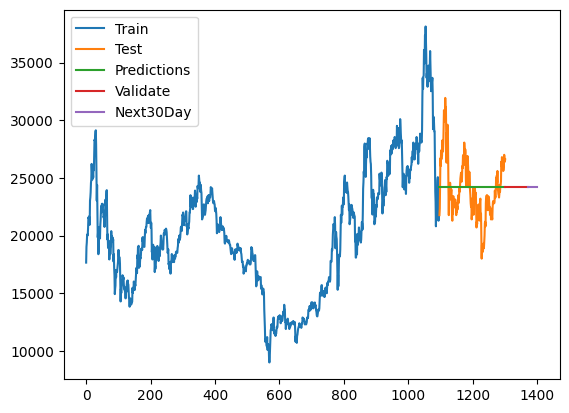

In [9]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# 9.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

In [10]:
test_data.index

RangeIndex(start=1097, stop=1302, step=1)

In [11]:
# Tính MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAPE và MDA
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val) ** 2))
test_rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
valid_mape = calculate_mape(y_val, y_pred_val)
test_mape = calculate_mape(y_test, y_pred)
valid_mda = calculate_mda(y_val, y_pred_val)
test_mda = calculate_mda(y_test, y_pred)

# In kết quả
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
print('Validation MDA:', valid_mda)
print('Testing MDA:', test_mda)

Validation RMSE: 3670.3970201756492
Testing RMSE: 2577.805229259961
Validation MAPE: 9.988412344316261
Testing MAPE: 8.545244891173434
Validation MDA: 13.043478260869565
Testing MDA: 5.88235294117647
